In [38]:
%reset -sf

import tensorflow as tf

print("Tensorflow:", tf.__version__)


# GPU(s) setups
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        
        # Instead of enabling memory growth, set a memory limit
        memory_limit = 48685 # Set the memory limit in MB
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)]
        )
        
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

Tensorflow: 2.13.0
2 Physical GPUs, 1 Logical GPU


In [39]:
import sys
import os
import glob

HOME_PATH = os.path.abspath("..")
sys.path.insert(0, HOME_PATH + "/qe")

import atlas_plot as ap
plot = ap.Plotter()

import pandas as pd
import numpy as np
import scipy as sp

from matplotlib import pyplot as plt

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"  # suppress tensorflow imformation messages

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

SEED = 42  # set random seed (global variable)
GEV = 1e-3

In [40]:
from dataclasses import dataclass

data_path = "/root/data/full_345324_data.h5"


def pt(px, py):
    return np.sqrt(np.square(px) + np.square(py))


def eta(px, py, pz):
    pt = np.sqrt(np.square(px) + np.square(py))
    return np.arcsinh(np.divide(pz, pt))


def phi(px, py):
    return np.arctan2(py, px)


def m(p4):
    return np.sqrt(
        np.square(p4[:, 3])
        - np.square(p4[:, 0])
        - np.square(p4[:, 1])
        - np.square(p4[:, 2])
    )


@dataclass
class Lead_lep:
    px = pd.read_hdf(data_path, "reco_leadlep")["RecoLeadLepPx"] * GEV
    py = pd.read_hdf(data_path, "reco_leadlep")["RecoLeadLepPy"] * GEV
    pz = pd.read_hdf(data_path, "reco_leadlep")["RecoLeadLepPz"] * GEV
    energy = pd.read_hdf(data_path, "reco_leadlep")["RecoLeadLepE"] * GEV
    pt = pd.read_hdf(data_path, "reco_leadlep")["RecoLeadLepPt"] * GEV
    eta = pd.read_hdf(data_path, "reco_leadlep")["RecoLeadLepEta"]
    phi = pd.read_hdf(data_path, "reco_leadlep")["RecoLeadLepPhi"]
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


@dataclass
class Sublead_lep:
    px = pd.read_hdf(data_path, "reco_subleadlep")["RecoSubleadLepPx"] * GEV
    py = pd.read_hdf(data_path, "reco_subleadlep")["RecoSubleadLepPy"] * GEV
    pz = pd.read_hdf(data_path, "reco_subleadlep")["RecoSubleadLepPz"] * GEV
    energy = pd.read_hdf(data_path, "reco_subleadlep")["RecoSubleadLepE"] * GEV
    pt = pd.read_hdf(data_path, "reco_subleadlep")["RecoSubleadLepPt"] * GEV
    eta = pd.read_hdf(data_path, "reco_subleadlep")["RecoSubleadLepEta"]
    phi = pd.read_hdf(data_path, "reco_subleadlep")["RecoSubleadLepPhi"]
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


@dataclass
class Dilep:
    lead = Lead_lep()
    sublead = Sublead_lep()
    p4 = Lead_lep.p4 + Sublead_lep.p4
    p3 = p4[:, :3]
    px = p4[:, 0]
    py = p4[:, 1]
    pz = p4[:, 2]
    energy = p4[:, 3]
    pt = pt(px, py)
    eta = eta(px, py, pz)
    phi = phi(px, py)
    m = m(p4)


@dataclass
class Met:
    px = pd.read_hdf(data_path, "reco_met")["RecoMETPx"] * GEV
    py = pd.read_hdf(data_path, "reco_met")["RecoMETPy"] * GEV
    phi = pd.read_hdf(data_path, "reco_met")["RecoMETPhi"]
    pt = pt(px, py)


@dataclass
class Truth_lead_lep:
    px = pd.read_hdf(data_path, "truth_leadlep")["TruthRecoLeadLepPx"] * GEV
    py = pd.read_hdf(data_path, "truth_leadlep")["TruthRecoLeadLepPy"] * GEV
    pz = pd.read_hdf(data_path, "truth_leadlep")["TruthRecoLeadLepPz"] * GEV
    energy = pd.read_hdf(data_path, "truth_leadlep")["TruthRecoLeadLepE"] * GEV
    pt = pd.read_hdf(data_path, "truth_leadlep")["TruthRecoLeadLepPt"] * GEV
    eta = pd.read_hdf(data_path, "truth_leadlep")["TruthRecoLeadLepEta"]
    phi = pd.read_hdf(data_path, "truth_leadlep")["TruthRecoLeadLepPhi"]
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


@dataclass
class Truth_sublead_lep:
    px = pd.read_hdf(data_path, "truth_subleadlep")["TruthRecoSubleadLepPx"] * GEV
    py = pd.read_hdf(data_path, "truth_subleadlep")["TruthRecoSubleadLepPy"] * GEV
    pz = pd.read_hdf(data_path, "truth_subleadlep")["TruthRecoSubleadLepPz"] * GEV
    energy = pd.read_hdf(data_path, "truth_subleadlep")["TruthRecoSubleadLepE"] * GEV
    pt = pd.read_hdf(data_path, "truth_subleadlep")["TruthRecoSubleadLepPt"] * GEV
    eta = pd.read_hdf(data_path, "truth_subleadlep")["TruthRecoSubleadLepEta"]
    phi = pd.read_hdf(data_path, "truth_subleadlep")["TruthRecoSubleadLepPhi"]
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


@dataclass
class Truth_dilep:
    lead = Truth_lead_lep()
    sublead = Truth_sublead_lep()
    p4 = Lead_lep.p4 + Sublead_lep.p4
    p3 = p4[:, :3]
    px = p4[:, 0]
    py = p4[:, 1]
    pz = p4[:, 2]
    energy = p4[:, 3]
    pt = pt(px, py)
    eta = eta(px, py, pz)
    phi = phi(px, py)
    m = m(p4)


@dataclass
class Truth_met:
    px = pd.read_hdf(data_path, "truth_met")["TruthRecoMETPx"] * GEV
    py = pd.read_hdf(data_path, "truth_met")["TruthRecoMETPy"] * GEV
    phi = pd.read_hdf(data_path, "truth_met")["TruthRecoMETPhi"]
    pt = pt(px, py)


@dataclass
class Lead_w:
    px = pd.read_hdf(data_path, "truth_leadw")["TruthRecoLeadWPx"] * GEV
    py = pd.read_hdf(data_path, "truth_leadw")["TruthRecoLeadWPy"] * GEV
    pz = pd.read_hdf(data_path, "truth_leadw")["TruthRecoLeadWPz"] * GEV
    energy = pd.read_hdf(data_path, "truth_leadw")["TruthRecoLeadWE"] * GEV
    pt = pd.read_hdf(data_path, "truth_leadw")["TruthRecoLeadWPt"] * GEV
    eta = pd.read_hdf(data_path, "truth_leadw")["TruthRecoLeadWEta"]
    phi = pd.read_hdf(data_path, "truth_leadw")["TruthRecoLeadWPhi"]
    m = pd.read_hdf(data_path, "truth_leadw")["TruthRecoLeadWM"] * GEV
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


@dataclass
class Sublead_w:
    px = pd.read_hdf(data_path, "truth_subleadw")["TruthRecoSubleadWPx"] * GEV
    py = pd.read_hdf(data_path, "truth_subleadw")["TruthRecoSubleadWPy"] * GEV
    pz = pd.read_hdf(data_path, "truth_subleadw")["TruthRecoSubleadWPz"] * GEV
    energy = pd.read_hdf(data_path, "truth_subleadw")["TruthRecoSubleadWE"] * GEV
    pt = pd.read_hdf(data_path, "truth_subleadw")["TruthRecoSubleadWPt"] * GEV
    eta = pd.read_hdf(data_path, "truth_subleadw")["TruthRecoSubleadWEta"]
    phi = pd.read_hdf(data_path, "truth_subleadw")["TruthRecoSubleadWPhi"]
    m = pd.read_hdf(data_path, "truth_subleadw")["TruthRecoSubleadWM"] * GEV
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T

In [41]:
# reco
lead_lep = Lead_lep()
sublead_lep = Sublead_lep()
dilep = Dilep()
met = Met()

# truth
truth_lead_lep = Truth_lead_lep()
truth_sublead_lep = Truth_sublead_lep()
Truth_dilep = Truth_dilep()
truth_met = Truth_met()

# target Ws
w_lead = Lead_w()
w_sublead = Sublead_w()

In [42]:
# define preselection cuts

cut_pre_pt_lead = lead_lep.pt > 22
print(len(lead_lep.energy) - np.sum(cut_pre_pt_lead * 1))
cut_pre_pt_sub = sublead_lep.pt > 15
print(len(lead_lep.energy) - np.sum(cut_pre_pt_sub * 1))
cut_pre_dilep_m = (
    np.sqrt(
        np.square(lead_lep.energy + sublead_lep.energy)
        - np.square(lead_lep.px + sublead_lep.px)
        - np.square(lead_lep.py + sublead_lep.py)
        - np.square(lead_lep.pz + sublead_lep.pz)
    )
    > 10
)
print(len(lead_lep.energy) - np.sum(cut_pre_dilep_m * 1))
cut_pre_pt_miss = met.pt > 20
print(len(lead_lep.energy) - np.sum(cut_pre_pt_miss * 1))
PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
print(len(lead_lep.energy) - np.sum(PRE_CUT * 1))
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

665
86425
17938
30738
123678


In [43]:
## Observing variables

obs_kin = np.column_stack(
    (
        lead_lep.px,
        lead_lep.py,
        lead_lep.pz,
        lead_lep.energy,
        lead_lep.pt,
        lead_lep.eta,
        lead_lep.phi,
        sublead_lep.px,
        sublead_lep.py,
        sublead_lep.pz,
        sublead_lep.energy,
        sublead_lep.pt,
        sublead_lep.eta,
        sublead_lep.phi,
        met.px,
        met.py,
        met.pt,
        met.phi,
        dilep.px,
        dilep.py,
        dilep.pz,
        dilep.energy,
        dilep.pt,
        dilep.eta,
        dilep.phi,
        dilep.m,
    )
)[PRE_CUT]

# Kinematics of observing variables (inputs for training)
print("int_kin shape:", obs_kin.shape)
# print(print(obs_kin.describe()))
# obs_kin = obs_kin.to_numpy() # convert to numpy array
ROBUST_OBS = RobustScaler()
obs_kin = ROBUST_OBS.fit_transform(obs_kin)
print(type(obs_kin))

int_kin shape: (234337, 26)
<class 'numpy.ndarray'>


In [44]:
## Interesting variables

w_lead_p4 = pd.DataFrame(w_lead.p4[PRE_CUT])
w_sublead_p4 = pd.DataFrame(w_sublead.p4[PRE_CUT])
w_lead_m = pd.DataFrame(w_lead.m[PRE_CUT])
w_sublead_m = pd.DataFrame(w_sublead.m[PRE_CUT])

# Kinematics of interesting variables (target for training)
int_kin = np.concatenate([w_lead_p4, np.square(w_lead_m) * 5e-2], axis=-1)
print("int_kin shape:", int_kin.shape)
# int_kin = int_kin.to_numpy()  # convert to numpy array
print(type(int_kin))

int_kin shape: (234337, 5)
<class 'numpy.ndarray'>


In [45]:
# Train test split

indices_arr = np.arange(int_kin.shape[0], dtype="int")
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(),
    train_size=0.9,
    test_size=0.1,
    random_state=SEED,
    shuffle=True,
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=SEED
)

train_x = obs_kin[train_indices]
test_x = obs_kin[test_indices]
valid_x = obs_kin[valid_indices]
test_x = np.concatenate([test_x, valid_x], axis=0)
train_y = int_kin[train_indices]
test_y = int_kin[test_indices]
valid_y = int_kin[valid_indices]
test_y = np.concatenate([test_y, valid_y], axis=0)

print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)

X (Interest)
Training data shape: (210903, 26);
Validing data shape: (11717, 26);
Testing data shape: (23434, 26).
Y (Observed)
Training data shape: (210903, 5);
Validing data shape: (11717, 5);
Testing data shape: (23434, 5).


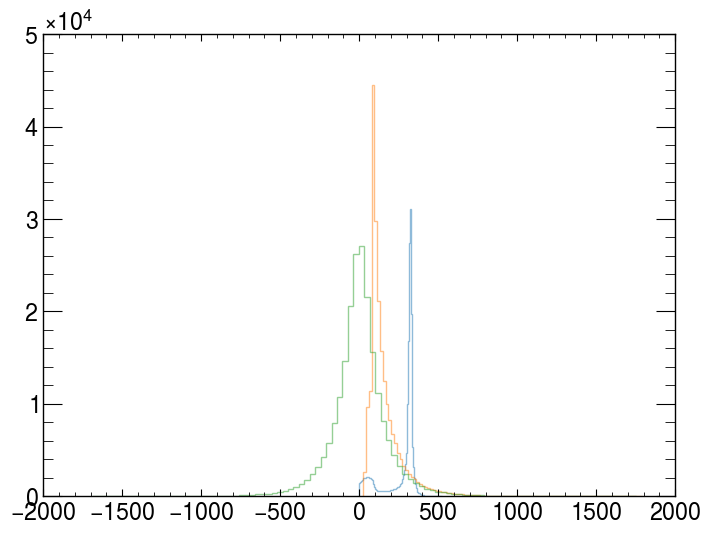

In [46]:
plt.hist(train_y[: ,-1], bins=100, alpha=.5, histtype='step')
plt.hist(train_y[: ,-2], bins=100, alpha=.5, histtype='step')
plt.hist(train_y[: ,-3], bins=100, alpha=.5, histtype='step')
# plt.hist(train_y[: ,-4], bins=100, alpha=.5, histtype='step')
plt.show()

In [47]:
# training variables
BATCH_SIZE = 4096
EPOCHS = 1024
LEARNING_RATE = 1e-4

In [48]:
# Define the model.
def build_model():
    # Input layer
    inputs = tf.keras.layers.Input(shape=(train_x.shape[-1],))
    x = tf.keras.layers.Flatten()(inputs)
    
    # residual block
    for _ in range(4):
        # res block
        x = tf.keras.layers.Dense(units=1024, activation="relu", kernel_regularizer="L1L2")(x)
        x = tf.keras.layers.Dropout(rate=0.2)(x)
        y = tf.keras.layers.Dense(units=1024, activation="relu", kernel_regularizer="L1L2")(x)
        y = tf.keras.layers.Dropout(rate=0.2)(y)
        y = tf.keras.layers.Dense(units=1024, activation="relu", kernel_regularizer="L1L2")(y)
        x = tf.keras.layers.Add()([y, x])  # Skip connection
        # identity block
        # x = tf.keras.layers.Dropout(rate=0.3)(x)
        x = tf.keras.layers.Dense(units=1024, activation="selu", kernel_regularizer="L2")(x)
        x = tf.keras.layers.Dropout(rate=0.4)(x)
        x = tf.keras.layers.Dense(units=1024, activation="selu")(x)
    
    # last layer
    outputs = tf.keras.layers.Dense(units=5, activation="linear")(x)
    
    # Compile model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss="mae",
    )

    return model

In [49]:
# Instantiate the model

model = build_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 26)]                 0         []                            
                                                                                                  
 flatten_1 (Flatten)         (None, 26)                   0         ['input_2[0][0]']             
                                                                                                  
 dense_51 (Dense)            (None, 1024)                 27648     ['flatten_1[0][0]']           
                                                                                                  
 dropout_30 (Dropout)        (None, 1024)                 0         ['dense_51[0][0]']            
                                                                                            

In [50]:
# Define data generators with reduced batch size
def data_generator(x, y, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = (
        dataset.shuffle(buffer_size=len(x))
        .batch(batch_size)
        .prefetch(tf.data.experimental.AUTOTUNE)
    )
    return dataset


# Create training and validation generators
train_generator = data_generator(train_x, train_y, BATCH_SIZE)
valid_generator = data_generator(test_x, test_y, BATCH_SIZE)

# Compile the model
model.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=LEARNING_RATE
    ),
)

# Early stopping and learning rate scheduler
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-5,
    patience=32,
    mode="auto",
    restore_best_weights=False,
)


def scheduler(epoch, lr):
    if epoch < 512:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1 * LEARNING_RATE))


lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Fit the model using generators
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=[stop_early, lr_scheduler],
    verbose=2,
)

Epoch 1/1024
52/52 - 8s - loss: 110.7935 - val_loss: 98.9277 - lr: 1.0000e-04 - 8s/epoch - 159ms/step
Epoch 2/1024
52/52 - 2s - loss: 89.8369 - val_loss: 79.2588 - lr: 1.0000e-04 - 2s/epoch - 33ms/step
Epoch 3/1024
52/52 - 2s - loss: 76.8367 - val_loss: 74.1482 - lr: 1.0000e-04 - 2s/epoch - 34ms/step
Epoch 4/1024
52/52 - 2s - loss: 72.9446 - val_loss: 70.5476 - lr: 1.0000e-04 - 2s/epoch - 32ms/step
Epoch 5/1024
52/52 - 2s - loss: 69.5085 - val_loss: 67.4160 - lr: 1.0000e-04 - 2s/epoch - 33ms/step
Epoch 6/1024
52/52 - 2s - loss: 66.7789 - val_loss: 65.0629 - lr: 1.0000e-04 - 2s/epoch - 33ms/step
Epoch 7/1024
52/52 - 2s - loss: 64.4594 - val_loss: 63.3360 - lr: 1.0000e-04 - 2s/epoch - 33ms/step
Epoch 8/1024
52/52 - 2s - loss: 61.4217 - val_loss: 59.2679 - lr: 1.0000e-04 - 2s/epoch - 33ms/step
Epoch 9/1024
52/52 - 2s - loss: 58.9598 - val_loss: 57.5113 - lr: 1.0000e-04 - 2s/epoch - 33ms/step
Epoch 10/1024
52/52 - 2s - loss: 56.8816 - val_loss: 54.3386 - lr: 1.0000e-04 - 2s/epoch - 33ms/st

In [51]:
# Make a directory
dir_name = HOME_PATH + "/7th_trial/ww_resregressor_result/"
name = "ww_resregressor_lead"

# If the directory exists
if os.path.exists(dir_name):
    test_files = glob.glob(dir_name + "*" + name + "*")
    if test_files:
        for file in test_files:
            os.remove(file)
        print(f"Directory {dir_name} cleaned.")
    print(f"Directory {dir_name} exists.")
else:
    os.makedirs(dir_name)
    print(f"Directory {dir_name} created.")

# save modela
model.save(dir_name + name + ".keras", save_format="keras", overwrite=True)

# predict
pred_y = model.predict(test_x)

# save predicted results
np.savez_compressed(dir_name + name + "_data.npz", pred_y=pred_y, test_y=test_y)
sig_pred = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth = np.load(dir_name + name + "_data.npz")["test_y"]

Directory /root/work/QE-mls/7th_trial/ww_resregressor_result/ cleaned.
Directory /root/work/QE-mls/7th_trial/ww_resregressor_result/ exists.
733/733 [==============================] - 2s 2ms/step


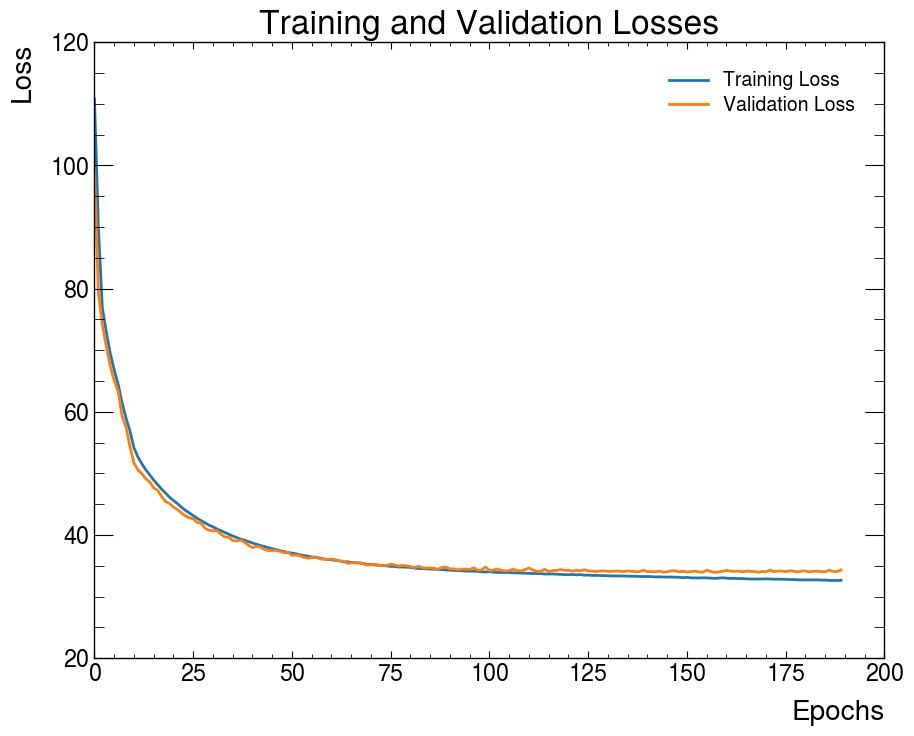

In [52]:
# Extract loss values
loss = history.history["loss"]
# lead_loss = history.history["lead_loss"]
# sublead_loss = history.history["sublead_loss"]
val_loss = history.history["val_loss"]
# val_lead_loss = history.history["val_lead_loss"]
# val_sublead_loss = history.history["val_sublead_loss"]

# Define colors for each metric
# colors = {
#     "loss": "blue",
#     "lead_loss": "green",
#     "sublead_loss": "red",
#     "val_loss": "blue",
#     "val_lead_loss": "green",
#     "val_sublead_loss": "red",
# }

# Plot training and validation losses
plt.figure(figsize=(10, 8))

plt.plot(loss, label="Training Loss")
# plt.plot(lead_loss, label="Training Lead Loss", color=colors["lead_loss"])
# plt.plot(sublead_loss, label="Training Sublead Loss", color=colors["sublead_loss"])
plt.plot(val_loss, label="Validation Loss")
# plt.plot(
#     val_lead_loss,
#     label="Validation Lead Loss",
#     linestyle="dashed",
#     color=colors["val_lead_loss"],
# )
# plt.plot(
#     val_sublead_loss,
#     label="Validation Sublead Loss",
#     linestyle="dashed",
#     color=colors["val_sublead_loss"],
# )

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Losses")
plt.legend()
plt.grid(False)
plt.show()

In [53]:
# save predicted results
np.savez_compressed(
    dir_name + name + "_data.npz",
    pred_y=sig_pred.reshape(sig_truth.shape),
    test_y=sig_truth,
)
sig_pred_inv = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth_inv = np.load(dir_name + name + "_data.npz")["test_y"]

Truth mean: -0.373, std: 39.706, min: -409.337, max: 481.755


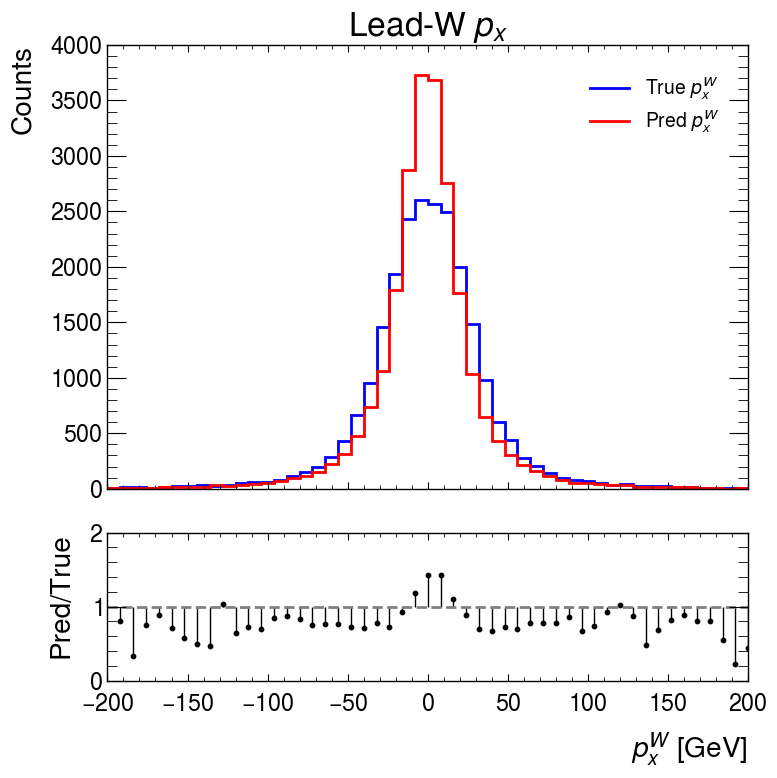

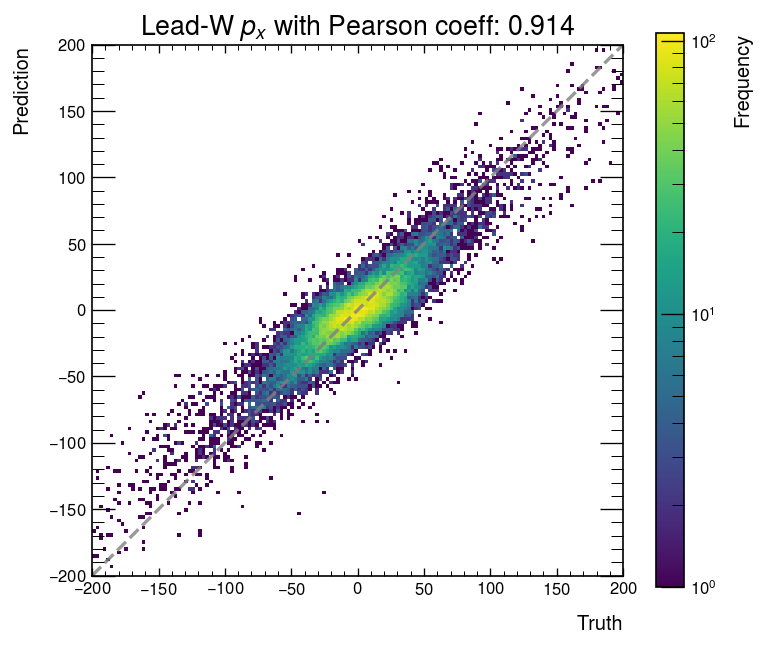

In [54]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,0]):.3f}, std: {np.std(sig_truth_inv[:,0]):.3f}, min: {np.min(sig_truth_inv[:,0]):.3f}, max: {np.max(sig_truth_inv[:,0]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 0], sig_pred_inv[:, 0]],
    label=r"$p_{x}^{W}$",
    title="Lead-W $p_{x}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,0], sig_pred_inv[:,0])):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 0],
    sig_pred_inv[:, 0],
    r"Lead-W $p_{x}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,0], sig_pred_inv[:,0])[0]:.3f}",
    range=set_range,
)

In [55]:
# print(
#     f"Truth mean: {np.mean(sig_truth_inv[:,4]):.3f}, std: {np.std(sig_truth_inv[:,4]):.3f}, min: {np.min(sig_truth_inv[:,4]):.3f}, max: {np.max(sig_truth_inv[:,4]):.3f}"
# )

# set_range = [-200, 200]

# plot.hist(
#     data=[sig_truth_inv[:, 4], sig_pred_inv[:, 4]],
#     label=r"$p_{x}^{W}$",
#     title="Sublead-W $p_{x}$",
#     # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,4], sig_pred_inv[:,4])):.3f}",
#     range=set_range,
#     unit="[GeV]",
# )

# plot.plot_2d_histogram(
#     sig_truth_inv[:, 4],
#     sig_pred_inv[:, 4],
#     r"Sublead-W $p_{x}$ "
#     + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,4], sig_pred_inv[:,4])[0]:.3f}",
#     range=set_range,
# )

Truth mean: 0.286, std: 39.860, min: -391.862, max: 431.745


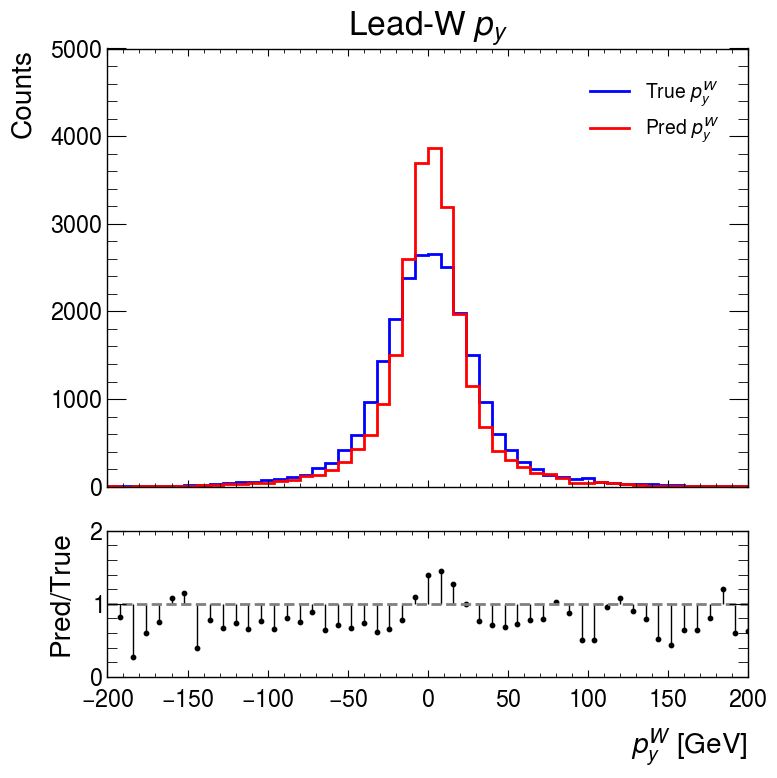

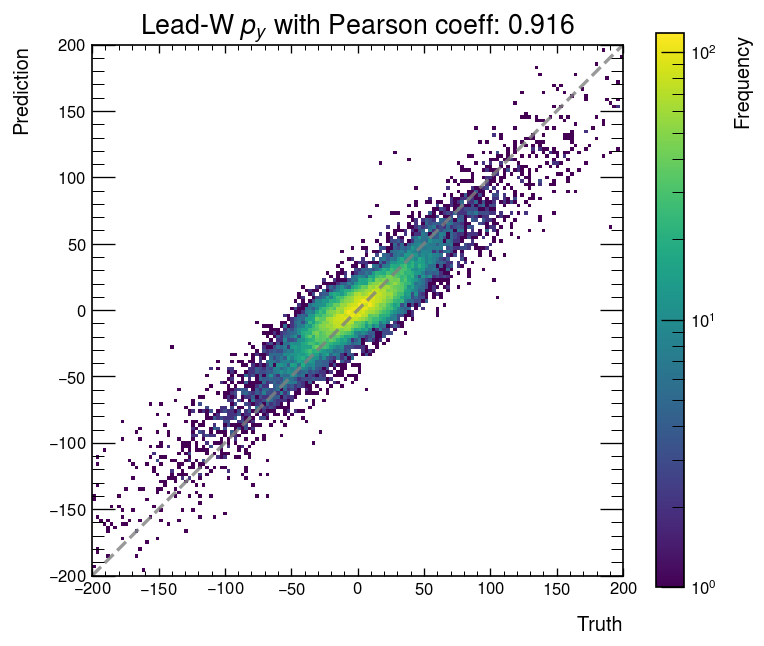

In [56]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,1]):.3f}, std: {np.std(sig_truth_inv[:,1]):.3f}, min: {np.min(sig_truth_inv[:,1]):.3f}, max: {np.max(sig_truth_inv[:,1]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 1], sig_pred_inv[:, 1]],
    label=r"$p_{y}^{W}$",
    title="Lead-W $p_{y}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,1], sig_pred_inv[:,1])):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 1],
    sig_pred_inv[:, 1],
    r"Lead-W $p_{y}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,1], sig_pred_inv[:,1])[0]:.3f}",
    range=set_range,
)

In [57]:
# print(
#     f"Truth mean: {np.mean(sig_truth_inv[:,5]):.3f}, std: {np.std(sig_truth_inv[:,5]):.3f}, min: {np.min(sig_truth_inv[:,5]):.3f}, max: {np.max(sig_truth_inv[:,5]):.3f}"
# )

# set_range = [-200, 200]

# plot.hist(
#     data=[sig_truth_inv[:, 5], sig_pred_inv[:, 5]],
#     label=r"$p_{y}^{W}$",
#     title="Sublead-W $p_{y}$",
#     # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,5], sig_pred_inv[:,5])):.3f}",
#     range=set_range,
#     unit="[GeV]",
# )

# plot.plot_2d_histogram(
#     sig_truth_inv[:, 5],
#     sig_pred_inv[:, 5],
#     r"Sublead-W $p_{y}$ "
#     + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,5], sig_pred_inv[:,5])[0]:.3f}",
#     range=set_range,
# )

Truth mean: -1.554, std: 173.533, min: -1156.594, max: 1674.743


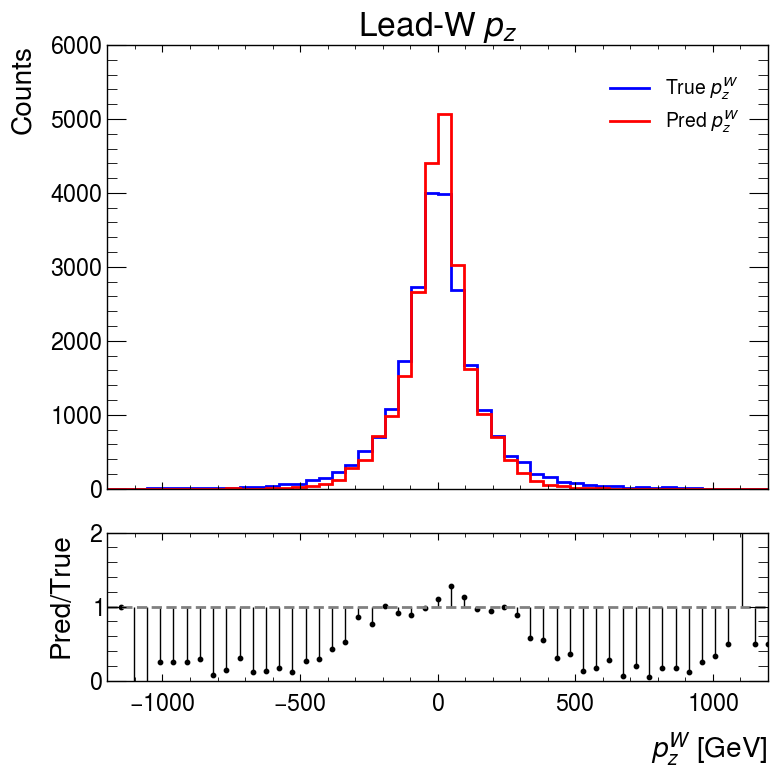

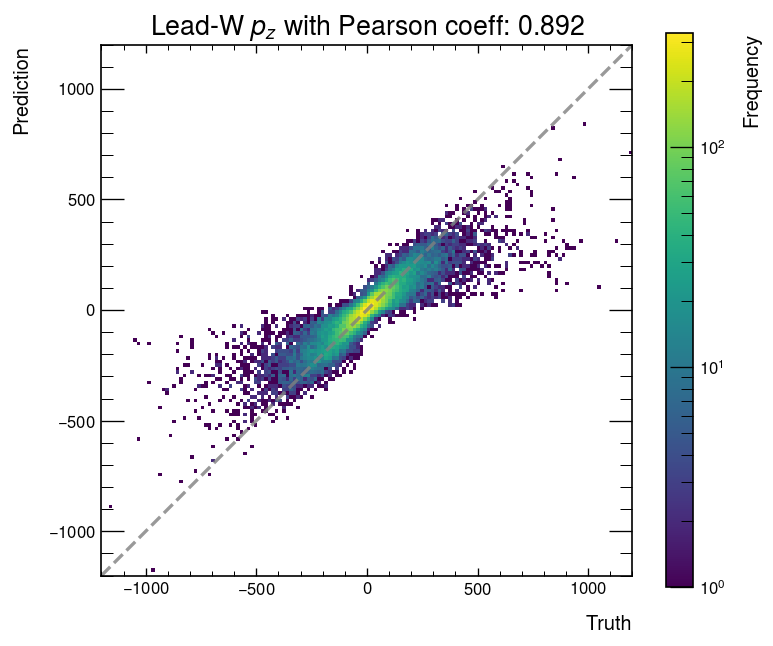

In [58]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,2]):.3f}, std: {np.std(sig_truth_inv[:,2]):.3f}, min: {np.min(sig_truth_inv[:,2]):.3f}, max: {np.max(sig_truth_inv[:,2]):.3f}"
)

set_range = [-1200, 1200]

plot.hist(
    data=[sig_truth_inv[:, 2], sig_pred_inv[:, 2]],
    label=r"$p_{z}^{W}$",
    title="Lead-W $p_{z}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,2], sig_pred_inv[:,2])):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 2],
    sig_pred_inv[:, 2],
    r"Lead-W $p_{z}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,2], sig_pred_inv[:,2])[0]:.3f}",
    range=set_range,
)

In [59]:
# print(
#     f"Truth mean: {np.mean(sig_truth_inv[:,6]):.3f}, std: {np.std(sig_truth_inv[:,6]):.3f}, min: {np.min(sig_truth_inv[:,6]):.3f}, max: {np.max(sig_truth_inv[:,6]):.3f}"
# )

# set_range = [-1200, 1200]

# plot.hist(
#     data=[sig_truth_inv[:, 6], sig_pred_inv[:, 6]],
#     label=r"$p_{z}^{W}$",
#     title="Sublead-W $p_{z}$",
#     # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,6], sig_pred_inv[:,6])):.3f}",
#     range=set_range,
#     unit="[GeV]",
# )

# plot.plot_2d_histogram(
#     sig_truth_inv[:, 6],
#     sig_pred_inv[:, 6],
#     r"Sublead-W $p_{z}$ "
#     + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,6], sig_pred_inv[:,6])[0]:.3f}",
#     range=set_range,
# )

Truth mean: 159.523, std: 114.467, min: 28.993, max: 1729.237


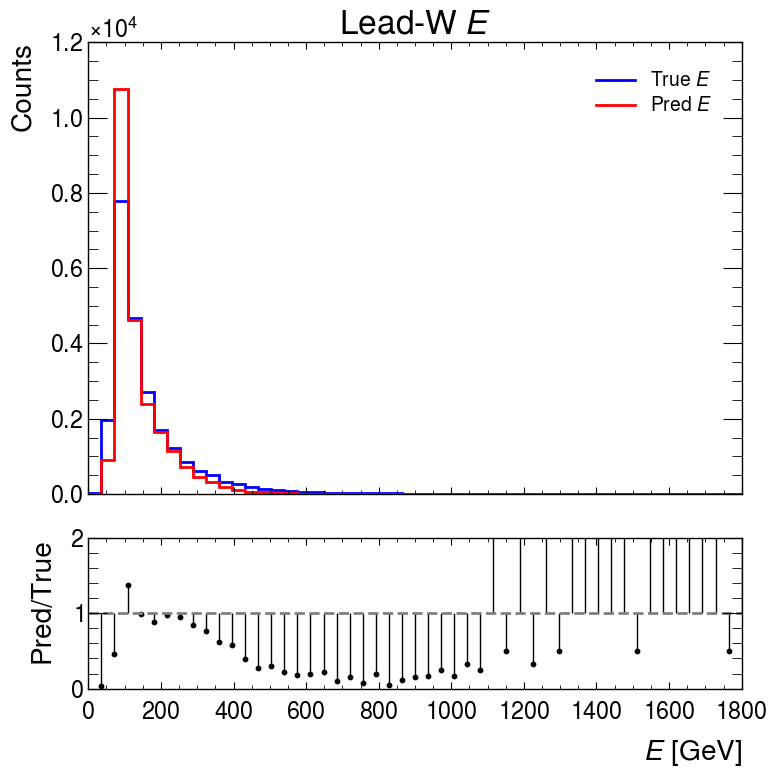

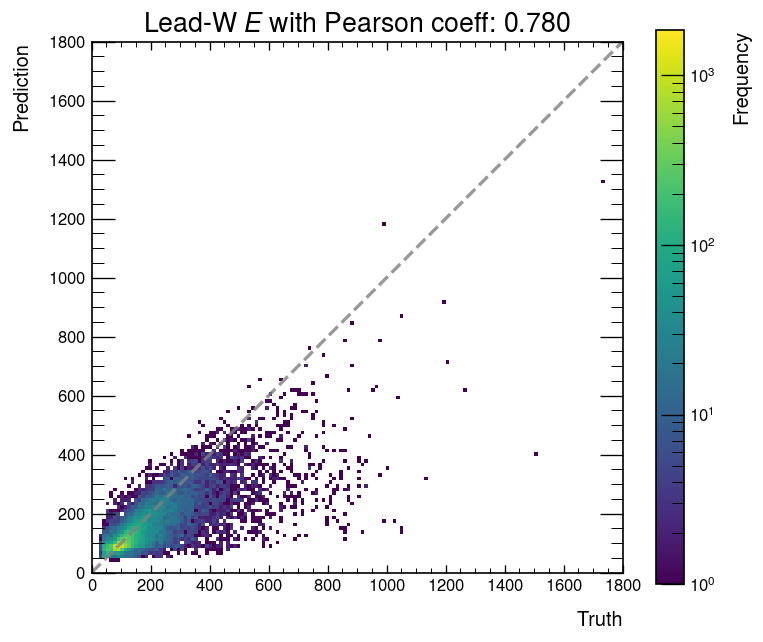

In [60]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,3]):.3f}, std: {np.std(sig_truth_inv[:,3]):.3f}, min: {np.min(sig_truth_inv[:,3]):.3f}, max: {np.max(sig_truth_inv[:,3]):.3f}"
)

set_range = [0, 1800]

plot.hist(
    data=[sig_truth_inv[:, 3], sig_pred_inv[:, 3]],
    label=r"$E$",
    title="Lead-W $E$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,3], sig_pred_inv[:,3])):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 3],
    sig_pred_inv[:, 3],
    r"Lead-W $E$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,3], sig_pred_inv[:,3])[0]:.3f}",
    range=set_range,
)

In [61]:
# print(
#     f"Truth mean: {np.mean(sig_truth_inv[:,7]):.3f}, std: {np.std(sig_truth_inv[:,7]):.3f}, min: {np.min(sig_truth_inv[:,7]):.3f}, max: {np.max(sig_truth_inv[:,7]):.3f}"
# )

# set_range = [0, 1800]

# plot.hist(
#     data=[sig_truth_inv[:, 7], sig_pred_inv[:, 7]],
#     label=r"$E$",
#     title="Sublead-W $E$",
#     # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,7], sig_pred_inv[:,7])):.3f}",
#     range=set_range,
#     unit="[GeV]",
# )

# plot.plot_2d_histogram(
#     sig_truth_inv[:, 7],
#     sig_pred_inv[:, 7],
#     r"Sublead-W $E$ "
#     + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,7], sig_pred_inv[:,7])[0]:.3f}",
#     range=set_range,
# )

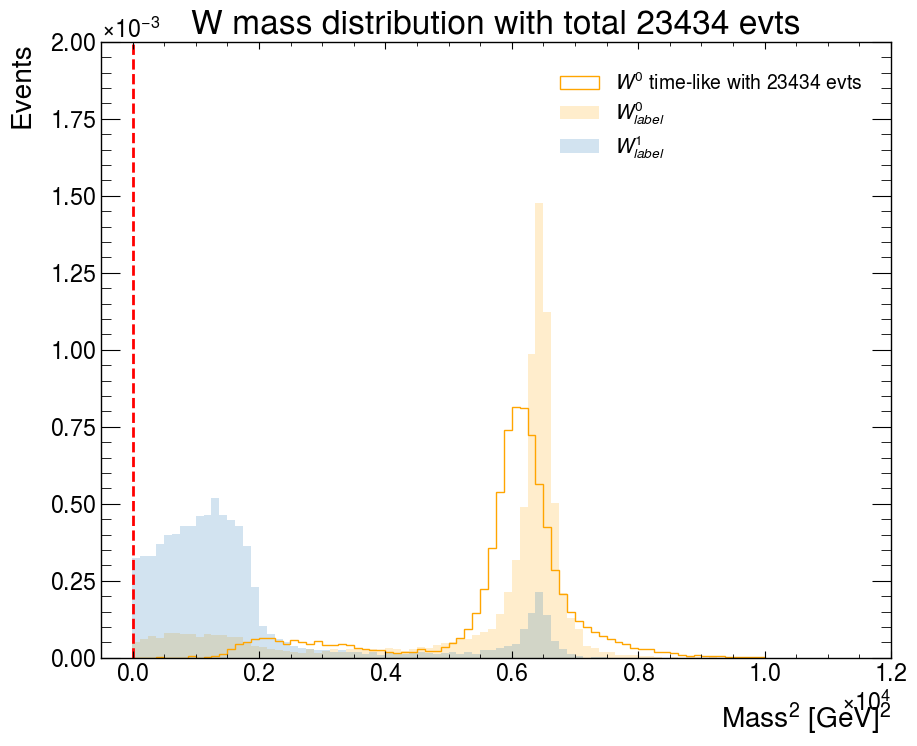

In [62]:
lead_time_like = np.square(sig_pred_inv[:, 3]) - np.sum(
    np.square(sig_pred_inv[:, 0:3]), axis=1
)
lead_time_mask = lead_time_like >= 0
# sublead_time_like = np.square(sig_pred_inv[:, 7]) - np.sum(
#     np.square(sig_pred_inv[:, 4:7]), axis=1
# )
# sublead_time_mask = sublead_time_like >= 0

bin_edges = np.linspace(-5, 1.0e4, 81)
figure = plt.figure(figsize=(10, 8))
plt.hist(lead_time_like, bins=bin_edges, fill=False, color="orange", histtype="step", label=r"$W^{0}$ " + f"time-like with {len(lead_time_mask)} evts",density=True)
# plt.hist(sublead_time_like, bins=bin_edges, fill=False, color="tab:blue", histtype="step", label=r"$W^{1}$ " + f"time-like with {len(sublead_time_mask)} evts",density=True)
plt.hist(np.square(w_lead.m[test_indices]), bins=bin_edges, color="orange", fill=True, histtype="bar", alpha=.2, label=r"$W_{label}^{0}$",density=True)
plt.hist(np.square(w_sublead.m[test_indices]), bins=bin_edges, color="tab:blue", fill=True, histtype="bar", alpha=.2, label=r"$W_{label}^{1}$",density=True)
plt.vlines(0, 0, 2e-3, color="red", linestyle="--")
plt.xlim(-5e2, 1.2e4)
plt.ylim(0, 2e-3)
plt.xlabel(r"Mass$^{2}$ [GeV]$^{2}$")
plt.ylabel("Events")
plt.title(f"W mass distribution with total {len(sig_pred_inv)} evts")
plt.legend(loc="upper right")
plt.show()

In [63]:
# validate by truth data

truth_lead_lep = Truth_lead_lep()
truth_sublead_lep = Truth_sublead_lep()
truth_met = Truth_met()

In [64]:
truth_obs_var = (
    np.column_stack(
        (
            truth_lead_lep.px,
            truth_lead_lep.py,
            truth_lead_lep.pz,
            truth_lead_lep.energy,
            truth_lead_lep.pt,
            truth_lead_lep.eta,
            truth_lead_lep.phi,
            truth_sublead_lep.px,
            truth_sublead_lep.py,
            truth_sublead_lep.pz,
            truth_sublead_lep.energy,
            truth_sublead_lep.pt,
            truth_sublead_lep.eta,
            truth_sublead_lep.phi,
            truth_met.px,
            truth_met.py,
            truth_met.pt,
            truth_met.phi,
            Truth_dilep.px,
            Truth_dilep.py,
            Truth_dilep.pz,
            Truth_dilep.energy,
            Truth_dilep.pt,
            Truth_dilep.eta,
            Truth_dilep.phi,
            Truth_dilep.m,
        ),
    )[PRE_CUT]
)

# truth labels
w_lead_truth_p4 = pd.DataFrame(w_lead.p4[PRE_CUT])
# w_sublead_truth_p4 = pd.DataFrame(w_sublead.p4[PRE_CUT])

TRUTH_ROBUST_OBS = RobustScaler()
truth_obs_var = TRUTH_ROBUST_OBS.fit_transform(truth_obs_var)

In [65]:
truth_pred_int = model.predict(truth_obs_var)
# truth_pred_int = np.concatenate([truth_pred_int[0], truth_pred_int[1]], axis=-1)

truth_pred_w_lead_px = truth_pred_int[:, 0]
truth_pred_w_lead_py = truth_pred_int[:, 1]
truth_pred_w_lead_pz = truth_pred_int[:, 2]
truth_pred_w_lead_energy = truth_pred_int[:, 3]
truth_pred_w_lead_p4 = np.vstack(
    [
        truth_pred_w_lead_px,
        truth_pred_w_lead_py,
        truth_pred_w_lead_pz,
        truth_pred_w_lead_energy,
    ]
).T
# truth_pred_w_sublead_px = truth_pred_int[:, 4]
# truth_pred_w_sublead_py = truth_pred_int[:, 5]
# truth_pred_w_sublead_pz = truth_pred_int[:, 6]
# truth_pred_w_sublead_energy = truth_pred_int[:, 7]
# truth_pred_w_sublead_p4 = np.vstack(
#     [
#         truth_pred_w_sublead_px,
#         truth_pred_w_sublead_py,
#         truth_pred_w_sublead_pz,
#         truth_pred_w_sublead_energy,
#     ]
# ).T

7324/7324 [==============================] - 18s 2ms/step


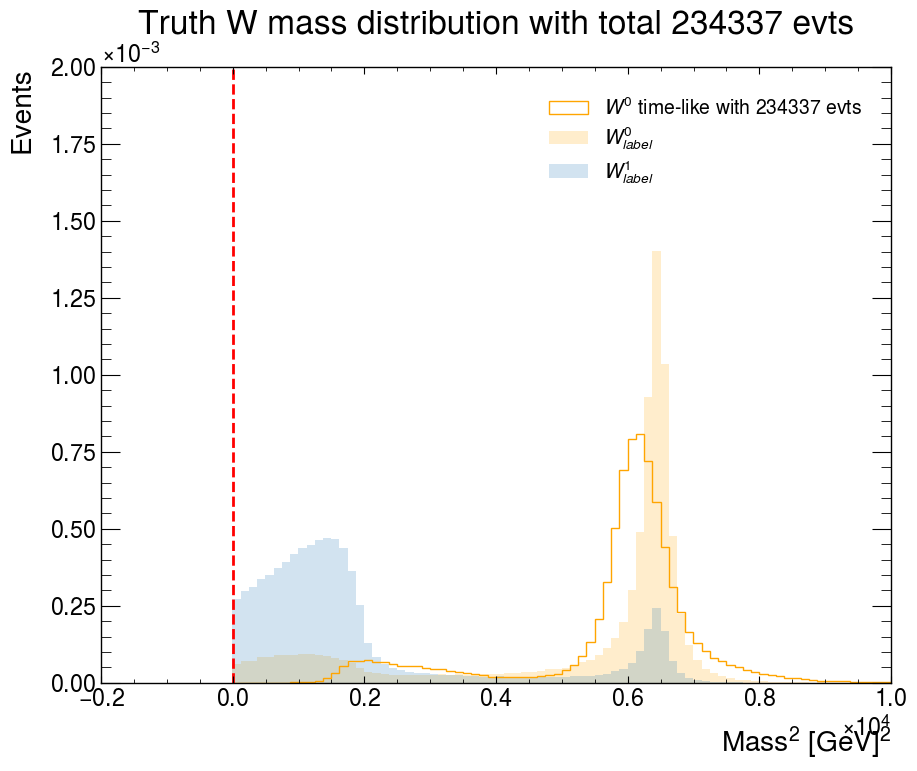

In [66]:
truth_lead_time_like = np.square(truth_pred_w_lead_p4[:, 3]) - np.sum(
    np.square(truth_pred_w_lead_p4[:, 0:-1]), axis=1
)
truth_lead_time_mask = truth_lead_time_like >= 0
# truth_sublead_time_like = np.square(truth_pred_w_sublead_p4[:, 3]) - np.sum(
#     np.square(truth_pred_w_sublead_p4[:, 0:-1]), axis=1
# )
# truth_sublead_time_mask = truth_sublead_time_like >= 0

bin_edges = np.linspace(-5, 1.0e4, 81)
figure = plt.figure(figsize=(10, 8))
plt.hist(truth_lead_time_like, bins=bin_edges, fill=False, color="orange", histtype="step", label=r"$W^{0}$ " + f"time-like with {len(truth_lead_time_mask)} evts", density=True)
# plt.hist(truth_sublead_time_like, bins=bin_edges, fill=False, color="tab:blue", histtype="step", label=r"$W^{1}$ " + f"time-like with {len(truth_sublead_time_mask)} evts", density=True)
plt.hist(np.square(w_lead.m[PRE_CUT]), bins=bin_edges, color="orange", fill=True, histtype="bar", alpha=.2, label=r"$W_{label}^{0}$", density=True)
plt.hist(np.square(w_sublead.m[PRE_CUT]), bins=bin_edges, color="tab:blue", fill=True, histtype="bar", alpha=.2, label=r"$W_{label}^{1}$", density=True)
plt.vlines(0, 0, 2e-3, color="red", linestyle="--")
plt.ylim(0, 2e-3)
plt.xlabel(r"Mass$^{2}$ [GeV]$^{2}$")
plt.ylabel("Events")
plt.title(f"Truth W mass distribution with total {len(truth_lead_time_like)} evts")
plt.legend(loc="best")
plt.show()

Truth mean: -0.028, std: 39.695, min: -680.455, max: 793.779


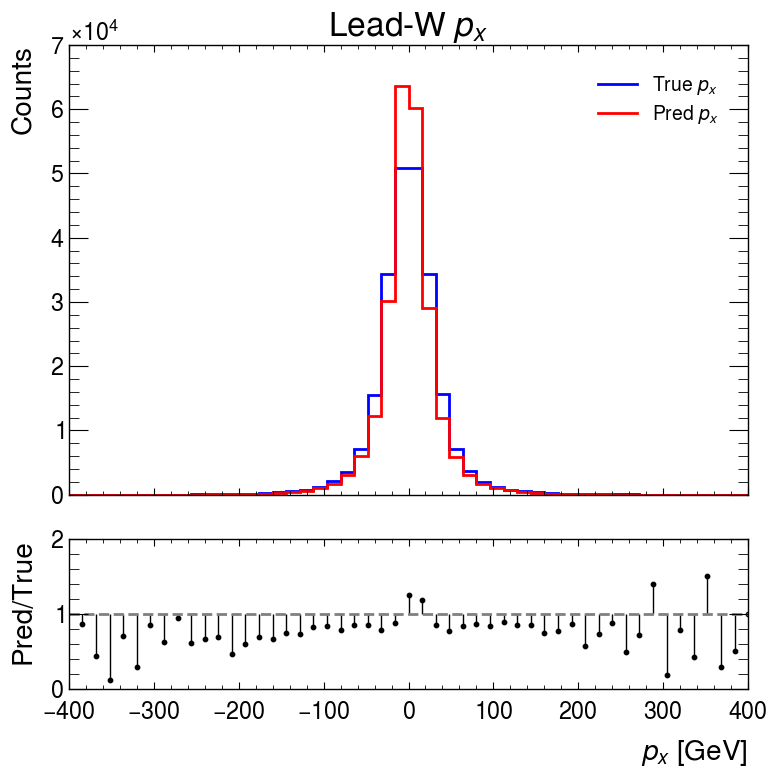

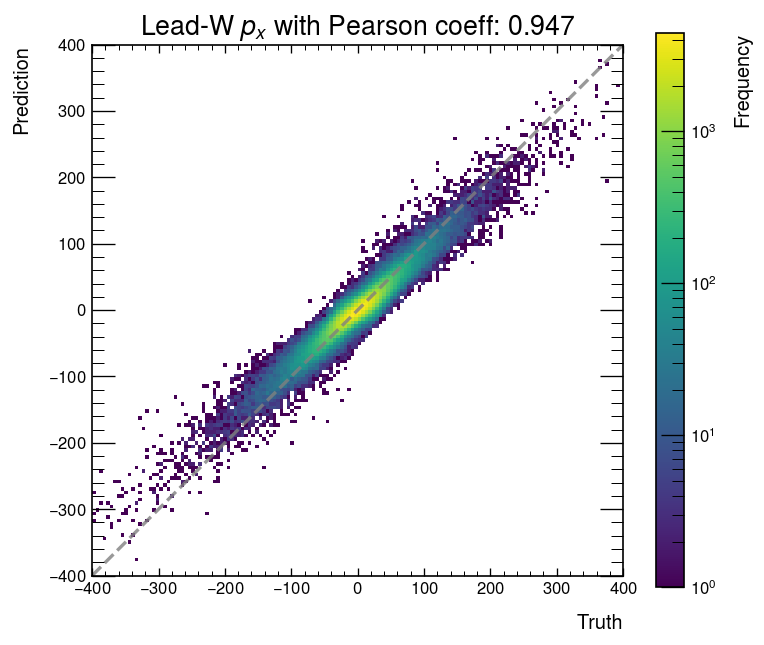

In [67]:
print(
    f"Truth mean: {np.mean(w_lead_truth_p4[0]):.3f}, std: {np.std(w_lead_truth_p4[0]):.3f}, min: {np.min(w_lead_truth_p4[0]):.3f}, max: {np.max(w_lead_truth_p4[0]):.3f}"
)

set_range = [-400, 400]

plot.hist(
    data=[w_lead_truth_p4[0], truth_pred_w_lead_p4[:, 0]],
    label=r"$p_{x}$",
    title="Lead-W $p_{x}$",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    w_lead_truth_p4[0],
    truth_pred_w_lead_p4[:, 0],
    r"Lead-W $p_{x}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(w_lead_truth_p4[0], truth_pred_w_lead_p4[:, 0])[0]:.3f}",
    range=set_range,
)

Truth mean: 0.024, std: 39.776, min: -664.730, max: 609.143


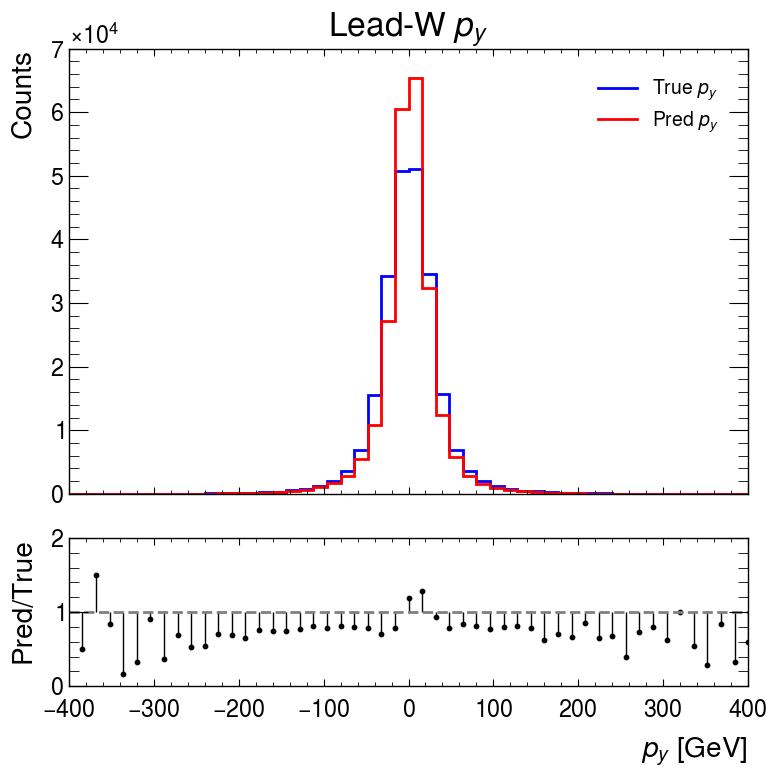

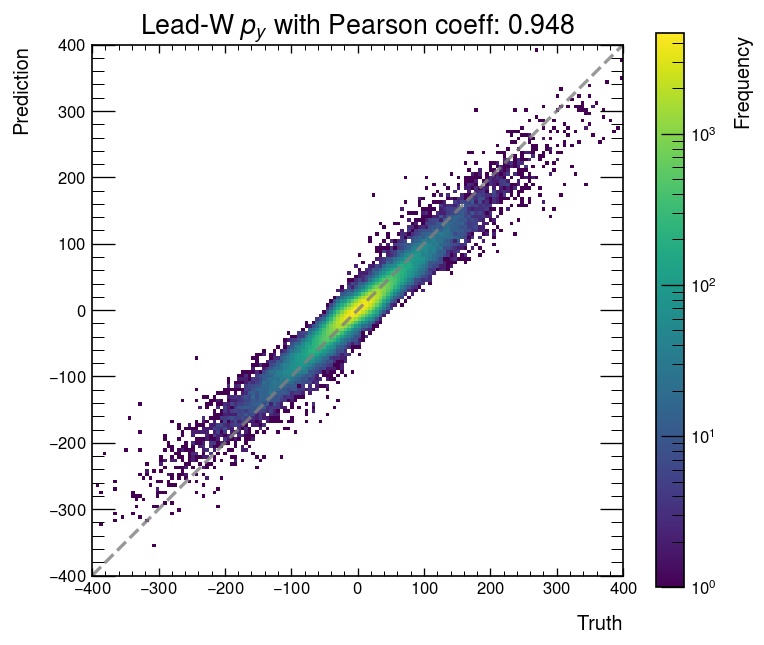

In [68]:
print(
    f"Truth mean: {np.mean(w_lead_truth_p4[1]):.3f}, std: {np.std(w_lead_truth_p4[1]):.3f}, min: {np.min(w_lead_truth_p4[1]):.3f}, max: {np.max(w_lead_truth_p4[1]):.3f}"
)

set_range = [-400, 400]

plot.hist(
    data=[w_lead_truth_p4[1], truth_pred_w_lead_p4[:, 1]],
    label=r"$p_{y}$",
    title="Lead-W $p_{y}$",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    w_lead_truth_p4[1],
    truth_pred_w_lead_p4[:, 1],
    r"Lead-W $p_{y}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(w_lead_truth_p4[1], truth_pred_w_lead_p4[:, 1])[0]:.3f}",
    range=set_range,
)

Truth mean: 0.034, std: 172.098, min: -1690.593, max: 1754.352


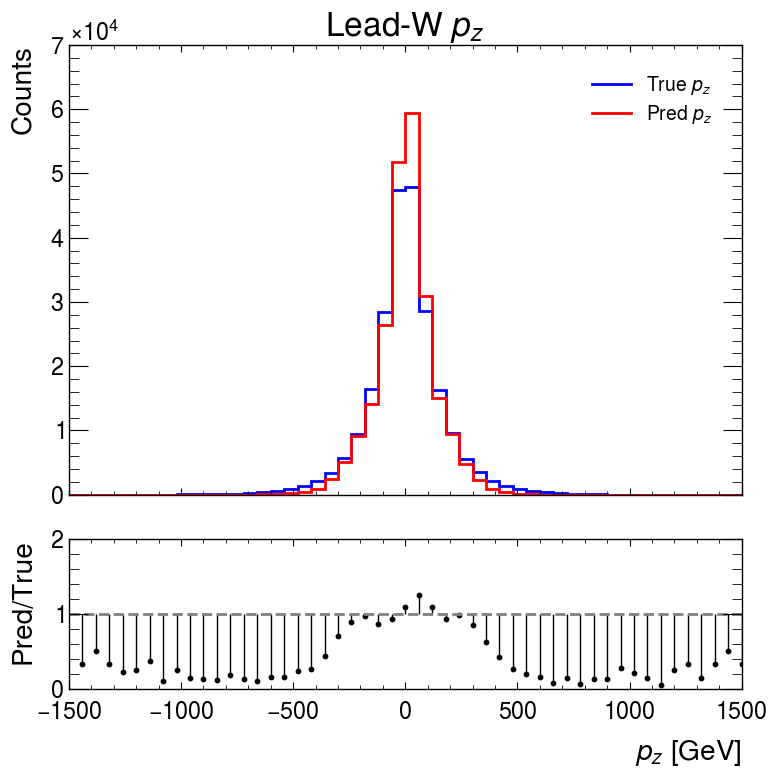

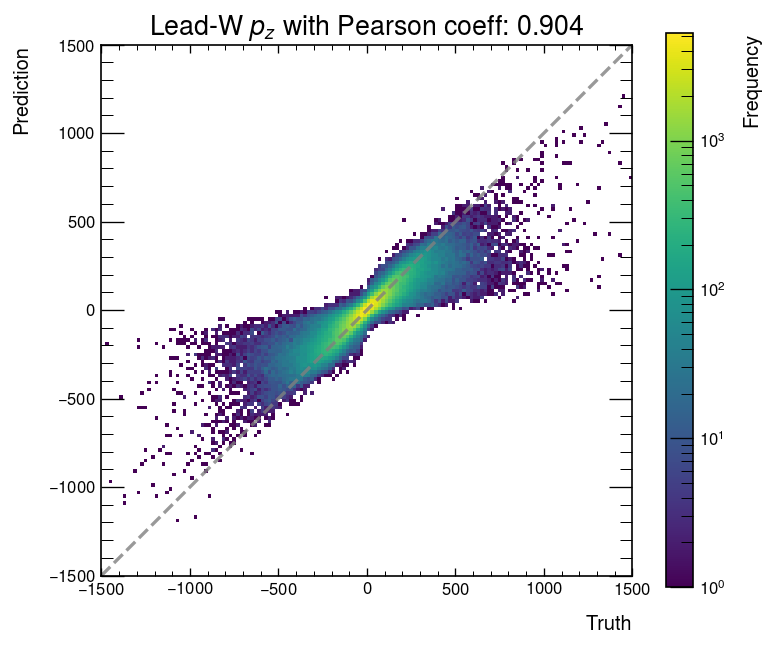

In [69]:
print(
    f"Truth mean: {np.mean(w_lead_truth_p4[2]):.3f}, std: {np.std(w_lead_truth_p4[2]):.3f}, min: {np.min(w_lead_truth_p4[2]):.3f}, max: {np.max(w_lead_truth_p4[2]):.3f}"
)

set_range = [-1500, 1500]

plot.hist(
    data=[w_lead_truth_p4[2], truth_pred_w_lead_p4[:, 2]],
    label=r"$p_{z}$",
    title="Lead-W $p_{z}$",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    w_lead_truth_p4[2],
    truth_pred_w_lead_p4[:, 2],
    r"Lead-W $p_{z}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(w_lead_truth_p4[2], truth_pred_w_lead_p4[:, 2])[0]:.3f}",
    range=set_range,
)

Truth mean: 158.839, std: 113.183, min: 26.392, max: 1791.292


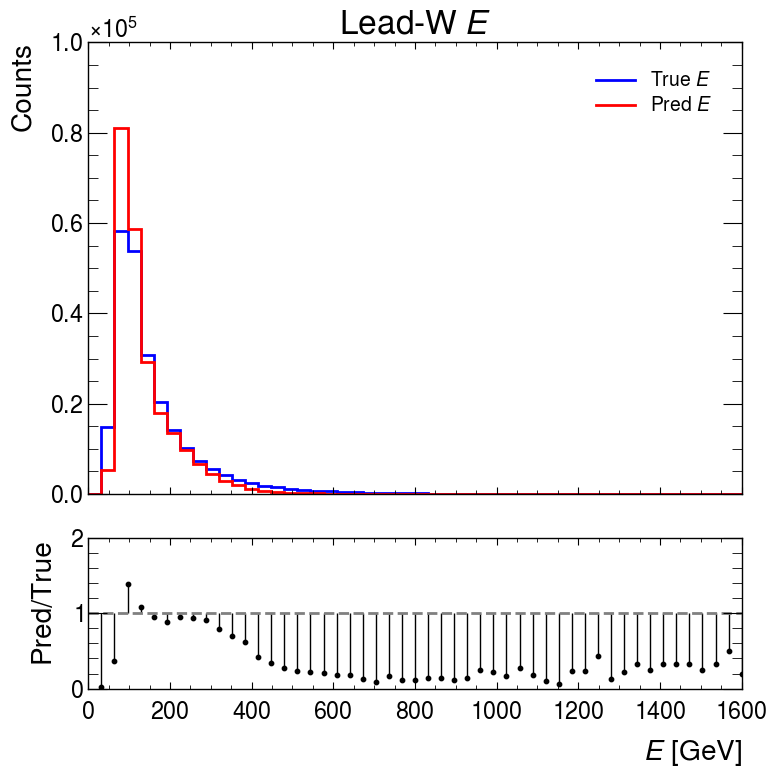

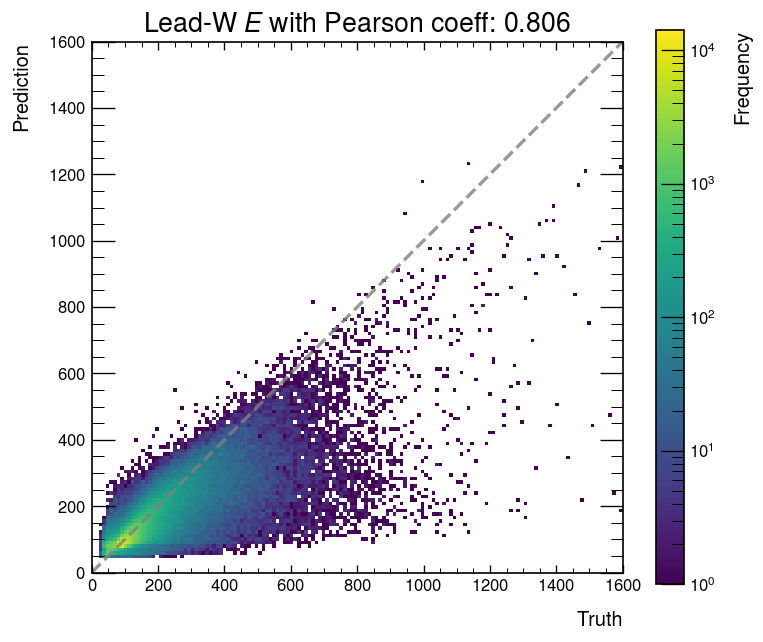

In [70]:
print(
    f"Truth mean: {np.mean(w_lead_truth_p4[3]):.3f}, std: {np.std(w_lead_truth_p4[3]):.3f}, min: {np.min(w_lead_truth_p4[3]):.3f}, max: {np.max(w_lead_truth_p4[3]):.3f}"
)

set_range = [0, 1600]

plot.hist(
    data=[w_lead_truth_p4[3], truth_pred_w_lead_p4[:, 3]],
    label=r"$E$",
    title="Lead-W $E$",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    w_lead_truth_p4[3],
    truth_pred_w_lead_p4[:, 3],
    r"Lead-W $E$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(w_lead_truth_p4[3], truth_pred_w_lead_p4[:, 3])[0]:.3f}",
    range=set_range,
)

In [71]:
# print(
#     f"Truth mean: {np.mean(w_sublead_truth_p4[0]):.3f}, std: {np.std(w_sublead_truth_p4[0]):.3f}, min: {np.min(w_sublead_truth_p4[0]):.3f}, max: {np.max(w_sublead_truth_p4[0]):.3f}"
# )

# set_range = [-400, 400]

# plot.hist(
#     data=[w_sublead_truth_p4[0], truth_pred_w_sublead_p4[:, 0]],
#     label=r"$p_{x}$",
#     title="Sublead-W $p_{x}$",
#     range=set_range,
#     unit="[GeV]",
# )

# plot.plot_2d_histogram(
#     w_sublead_truth_p4[0],
#     truth_pred_w_sublead_p4[:, 0],
#     r"Sublead-W $p_{x}$ "
#     + f"with Pearson coeff: {sp.stats.pearsonr(w_sublead_truth_p4[0], truth_pred_w_sublead_p4[:, 0])[0]:.3f}",
#     range=set_range,
# )

In [72]:
# print(
#     f"Truth mean: {np.mean(w_sublead_truth_p4[1]):.3f}, std: {np.std(w_sublead_truth_p4[1]):.3f}, min: {np.min(w_sublead_truth_p4[1]):.3f}, max: {np.max(w_sublead_truth_p4[1]):.3f}"
# )

# set_range = [-400, 400]

# plot.hist(
#     data=[w_sublead_truth_p4[1], truth_pred_w_sublead_p4[:, 1]],
#     label=r"$p_{y}$",
#     title="Sublead-W $p_{y}$",
#     range=set_range,
#     unit="[GeV]",
# )

# plot.plot_2d_histogram(
#     w_sublead_truth_p4[1],
#     truth_pred_w_sublead_p4[:, 1],
#     r"Sublead-W $p_{y}$ "
#     + f"with Pearson coeff: {sp.stats.pearsonr(w_sublead_truth_p4[1], truth_pred_w_sublead_p4[:, 1])[0]:.3f}",
#     range=set_range,
# )

In [73]:
# print(
#     f"Truth mean: {np.mean(w_sublead_truth_p4[2]):.3f}, std: {np.std(w_sublead_truth_p4[2]):.3f}, min: {np.min(w_sublead_truth_p4[2]):.3f}, max: {np.max(w_sublead_truth_p4[2]):.3f}"
# )

# set_range = [-1200, 1200]

# plot.hist(
#     data=[w_sublead_truth_p4[2], truth_pred_w_sublead_p4[:, 2]],
#     label=r"$p_{z}$",
#     title="Sublead-W $p_{z}$",
#     range=set_range,
#     unit="[GeV]",
# )

# plot.plot_2d_histogram(
#     w_sublead_truth_p4[2],
#     truth_pred_w_sublead_p4[:, 2],
#     r"Sublead-W $p_{z}$ "
#     + f"with Pearson coeff: {sp.stats.pearsonr(w_sublead_truth_p4[2], truth_pred_w_sublead_p4[:, 2])[0]:.3f}",
#     range=set_range,
# )

In [74]:
# print(
#     f"Truth mean: {np.mean(w_sublead_truth_p4[3]):.3f}, std: {np.std(w_sublead_truth_p4[3]):.3f}, min: {np.min(w_sublead_truth_p4[3]):.3f}, max: {np.max(w_sublead_truth_p4[3]):.3f}"
# )

# set_range = [0, 600]

# plot.hist(
#     data=[w_sublead_truth_p4[3], truth_pred_w_sublead_p4[:, 3]],
#     label=r"$E$",
#     title="Sublead-W $E$",
#     range=set_range,
#     unit="[GeV]",
# )

# plot.plot_2d_histogram(
#     w_sublead_truth_p4[3],
#     truth_pred_w_sublead_p4[:, 3],
#     r"Sublead-W $E$ "
#     + f"with Pearson coeff: {sp.stats.pearsonr(w_sublead_truth_p4[3], truth_pred_w_sublead_p4[:, 3])[0]:.3f}",
#     range=set_range,
# )